In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

plt.style.use("ggplot")

BASE_DATA_DIR = os.path.abspath("../data")
print("Using base data directory:", BASE_DATA_DIR)

Using base data directory: /work/data


In [2]:
json_files = glob(os.path.join(BASE_DATA_DIR, "**/*.json"), recursive=True)

print("Found JSON files:")
for f in json_files:
    print("  ", f)

print("\nTotal JSON files:", len(json_files))


Found JSON files:
   /work/data/GFTYRV/project-4-at-2025-10-30-12-12-aaf7a367.json

Total JSON files: 1


In [3]:
def strip_guid(filename):
    """
    Converts 'e2ab0dd4-FILENAME.csv' → 'FILENAME.csv'.
    """
    base = os.path.basename(filename)
    parts = base.split("-", 1)
    if len(parts) == 2:
        return parts[1]
    return base


In [4]:
def extract_segments(json_entry, csv_directory):
    """
    Extracts all labeled time segments from the annotation entry.
    Loads the corresponding CSV and slices the time range.
    Returns a list of segment dicts.
    """

    guid_name = json_entry["file_upload"]  # e.g., e2ab0dd4-GSPC_...
    clean_name = strip_guid(guid_name)

    # Try loading the CSV
    csv_path = os.path.join(csv_directory, guid_name)
    alt_path = os.path.join(csv_directory, clean_name)

    if os.path.exists(csv_path):
        full_csv_path = csv_path
    elif os.path.exists(alt_path):
        full_csv_path = alt_path
    else:
        print("WARNING: Cannot find CSV for annotation:", guid_name)
        return []

    try:
        df_csv = pd.read_csv(full_csv_path)
    except Exception as e:
        print("ERROR reading CSV:", full_csv_path, e)
        return []

    segments = []
    annotation = json_entry["annotations"][0]

    for result in annotation["result"]:
        val = result["value"]

        start = val["start"]
        end = val["end"]
        label = val["timeserieslabels"][0]

        seg_df = df_csv[(df_csv["timestamp"] >= start) & (df_csv["timestamp"] <= end)].copy()

        seg_df.reset_index(drop=True, inplace=True)

        segments.append({
            "csv_file": clean_name,
            "start": start,
            "end": end,
            "label": label,
            "length": len(seg_df),
            "segment_data": seg_df
        })

    return segments


In [5]:
all_segments = []

for json_path in json_files:
    print("\nProcessing:", json_path)

    folder = os.path.dirname(json_path)

    try:
        with open(json_path, "r", encoding="utf-8") as f:
            entries = json.load(f)
    except Exception as e:
        print("ERROR reading JSON:", json_path, e)
        continue

    for entry in entries:
        segs = extract_segments(entry, folder)
        all_segments.extend(segs)

print("\nTotal labeled segments loaded:", len(all_segments))



Processing: /work/data/GFTYRV/project-4-at-2025-10-30-12-12-aaf7a367.json

Total labeled segments loaded: 58


In [6]:
df_meta = pd.DataFrame([{
    "csv_file": seg["csv_file"],
    "label": seg["label"],
    "start": seg["start"],
    "end": seg["end"],
    "length": seg["length"]
} for seg in all_segments])

df_meta


,csv_file,label,start,end,length
0,GSPC_2025-09-25_to_2025-09-29_5m.csv,Bearish Pennant,2025-09-29 15:00,2025-09-29 16:00,13
1,GSPC_2025-09-25_to_2025-09-29_5m.csv,Bearish Wedge,2025-09-26 13:55,2025-09-26 15:30,20
2,GSPC_2025-09-25_to_2025-09-29_5m.csv,Bullish Pennant,2025-09-25 13:40,2025-09-25 14:45,14
3,GSPC_2025-09-30_to_2025-10-04_5m.csv,Bearish Pennant,2025-10-02 13:30,2025-10-02 15:35,26
4,GSPC_2025-10-05_to_2025-10-09_5m.csv,Bearish Wedge,2025-10-07 13:30,2025-10-07 17:45,52
5,GSPC_2025-10-10_to_2025-10-14_5m.csv,Bullish Pennant,2025-10-14 13:40,2025-10-14 15:30,23
6,GSPC_2025-10-15_to_2025-10-19_5m.csv,Bullish Wedge,2025-10-17 15:25,2025-10-17 16:45,17
7,GSPC_2025-10-20_to_2025-10-24_5m.csv,Bullish Normal,2025-10-20 13:55,2025-10-20 16:45,35
8,GSPC_2025-10-20_to_2025-10-24_5m.csv,Bullish Wedge,2025-10-21 14:25,2025-10-21 15:45,17
9,NDX_2025-09-05_to_2025-09-09_5m.csv,Bearish Wedge,2025-09-08 15:55,2025-09-08 19:00,38


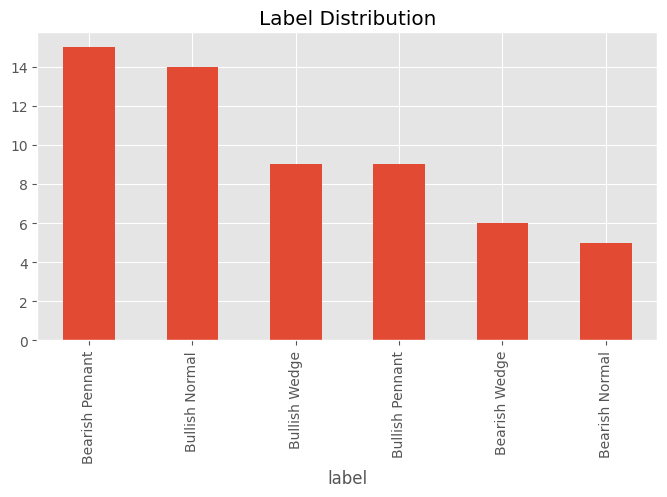

label
Bearish Pennant    15
Bullish Normal     14
Bullish Wedge       9
Bullish Pennant     9
Bearish Wedge       6
Bearish Normal      5
Name: count, dtype: int64

In [7]:
df_meta["label"].value_counts().plot(kind="bar", figsize=(8,4))
plt.title("Label Distribution")
plt.show()

df_meta["label"].value_counts()


Min length: 7
Max length: 73
Mean length: 28.189655172413794
Median length: 24.5


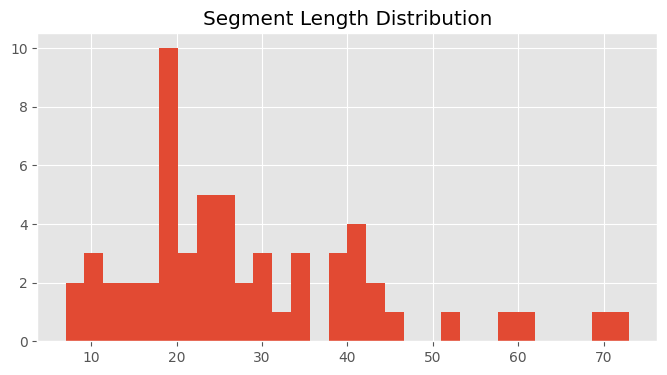

In [8]:
lengths = df_meta["length"].values

print("Min length:", lengths.min())
print("Max length:", lengths.max())
print("Mean length:", lengths.mean())
print("Median length:", np.median(lengths))

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=30)
plt.title("Segment Length Distribution")
plt.show()


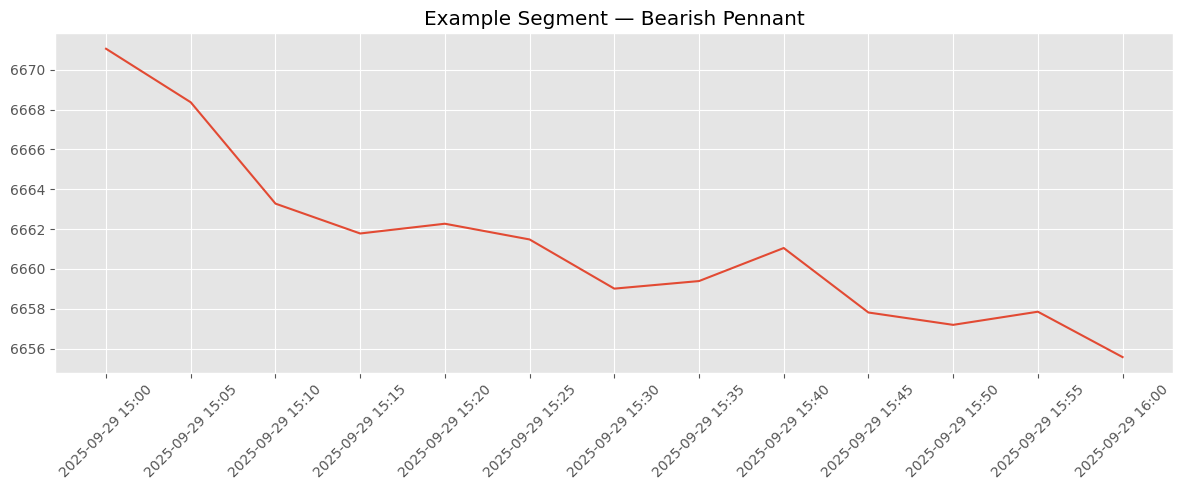

seg_df columns: Index(['timestamp', 'Open', 'High', 'Low', 'Close'], dtype='object')
          timestamp         Open         High          Low        Close
0  2025-09-29 15:00  6670.169922  6671.689941  6669.669922  6671.060059
1  2025-09-29 15:05  6671.100098  6671.370117  6668.310059  6668.370117
2  2025-09-29 15:10  6668.450195  6668.529785  6663.020020  6663.279785
3  2025-09-29 15:15  6663.169922  6663.169922  6658.319824  6661.779785
4  2025-09-29 15:20  6661.759766  6665.299805  6659.799805  6662.270020


In [9]:
sample = all_segments[0]
seg_df = sample["segment_data"]

plt.figure(figsize=(12,5))
plt.plot(seg_df["timestamp"], seg_df["Close"], label="Close Price")
plt.title(f"Example Segment — {sample['label']}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("seg_df columns:", seg_df.columns)
print(seg_df.head())

In [10]:
dataset = []

for seg in all_segments:
    dataset.append({
        "label": seg["label"],
        "csv_file": seg["csv_file"],
        "data": seg["segment_data"]
    })

len(dataset)


58

In [11]:
print("Total labeled segments:", len(dataset))
print("Unique labels:", df_meta["label"].unique())
df_meta.describe()


Total labeled segments: 58
Unique labels: ['Bearish Pennant' 'Bearish Wedge' 'Bullish Pennant' 'Bullish Wedge'
 'Bullish Normal' 'Bearish Normal']


,length
count,58.000000
mean,28.189655
std,14.565589
min,7.000000
25%,19.000000
50%,24.500000
75%,37.250000
max,73.000000


In [12]:
# Persist loaded data to the workspace data directory
import os
import pickle
import h5py
import numpy as np

EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
os.makedirs(EXPORT_DIR, exist_ok=True)
print("Exporting data to:", EXPORT_DIR)

# 1) Save metadata summary
meta_csv_path = os.path.join(EXPORT_DIR, "segments_meta.csv")
df_meta.to_csv(meta_csv_path, index=False)
print("Saved metadata CSV:", meta_csv_path)

# 2) Save full segments to HDF5 (efficient, reloadable)
h5_path = os.path.join(EXPORT_DIR, "segments.h5")
with h5py.File(h5_path, "w") as h5:
    grp = h5.create_group("segments")
    for i, seg in enumerate(all_segments):
        sgrp = grp.create_group(str(i))
        # Store attributes
        sgrp.attrs["label"] = seg["label"]
        sgrp.attrs["csv_file"] = seg["csv_file"]
        sgrp.attrs["start"] = seg["start"]
        sgrp.attrs["end"] = seg["end"]
        sgrp.attrs["length"] = seg["length"]
        # Store the segment dataframe with numeric values only
        seg_df = seg["segment_data"].copy()
        cols = seg_df.columns.tolist()
        # If timestamp exists, replace it with a sequential integer index
        if "timestamp" in seg_df.columns:
            seq_index = np.arange(len(seg_df), dtype=np.int64)
            sgrp.create_dataset("seq_index", data=seq_index)
            seg_df = seg_df.drop(columns=["timestamp"])  # drop original timestamp
            cols = seg_df.columns.tolist()
        sgrp.create_dataset("columns", data=[c.encode("utf-8") for c in cols])
        # Convert remaining columns to numeric and save as float64
        num_df = seg_df.apply(pd.to_numeric, errors="coerce")
        values = num_df.to_numpy(dtype=np.float64)
        sgrp.create_dataset("values", data=values)
print("Saved HDF5 segments:", h5_path)

# 3) Save a simple pickle backup (list of dicts)
pkl_path = os.path.join(EXPORT_DIR, "dataset.pkl")
with open(pkl_path, "wb") as f:
    pickle.dump({"df_meta": df_meta, "all_segments": all_segments}, f)
print("Saved pickle dataset:", pkl_path)

# 4) Save combined CSV with same content as HDF5
#    Schema: segment_id, label, csv_file, seq_index (0..N-1), and numeric columns
combined_csv_path = os.path.join(EXPORT_DIR, "segments_values.csv")
import pandas as pd
rows = []
for i, seg in enumerate(all_segments):
    seg_df = seg["segment_data"].copy()
    # Build sequential index regardless of timestamp presence
    seq_index = np.arange(len(seg_df), dtype=np.int64)
    # Drop timestamp if present
    if "timestamp" in seg_df.columns:
        seg_df = seg_df.drop(columns=["timestamp"])  # numeric columns remain
    # Coerce to numeric
    seg_df = seg_df.apply(pd.to_numeric, errors="coerce")
    # Attach metadata and seq index
    seg_df.insert(0, "seq_index", seq_index)
    seg_df.insert(0, "csv_file", seg["csv_file"])
    seg_df.insert(0, "label", seg["label"])
    seg_df.insert(0, "segment_id", i)
    rows.append(seg_df)
if rows:
    combined_df = pd.concat(rows, axis=0, ignore_index=True)
    combined_df.to_csv(combined_csv_path, index=False)
    print("Saved combined segments CSV:", combined_csv_path)
else:
    print("No segments to export to CSV.")

Exporting data to: /work/data/export
Saved metadata CSV: /work/data/export/segments_meta.csv
Saved HDF5 segments: /work/data/export/segments.h5
Saved pickle dataset: /work/data/export/dataset.pkl
Saved combined segments CSV: /work/data/export/segments_values.csv
Saved HDF5 segments: /work/data/export/segments.h5
Saved pickle dataset: /work/data/export/dataset.pkl
Saved combined segments CSV: /work/data/export/segments_values.csv
